In [15]:
import pandas as pd

file_path = r'C:\Users\andrew.dilley\development\URGS\HistoricDebtProfile.csv'

# Load the CSV data into a DataFrame
df = pd.read_csv(file_path)



# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(df.describe())
df.columns      # list of all column names


First 5 rows of the dataset:
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit
0             201718     12   121488    30084795   Social Security       0.95
1             201920     12    55628    30059774   Social Security       0.00
2             202122     12   124737    30099129   Social Security      74.90
3             201920     12    73972    30088800   Social Security     178.91
4             201718     12     2704    10003327   Social Security     171.72

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41067 non-null  int64  
 1   month              41067 non-null  int64  
 2   pk_porg            41067 non-null  int64  
 3   pk_account         41067 non-null  int64  
 4   pension_type_desc  39445 non-null  object 
 5   amt_debit          41067 non-n

Index(['fk_financial_year', 'month', 'pk_porg', 'pk_account',
       'pension_type_desc', 'amt_debit'],
      dtype='object')

In [16]:
# ensure fk_financial_year is stringy, then slice and convert to int
df['calendar_year'] = (
    df['fk_financial_year']
    .astype(str)    # in case it’s numeric
    .str[:4]        # grab the first four characters
    .astype(int)    # convert back to integer
)


In [17]:
# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(df.describe())


First 5 rows of the dataset:
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit  \
0             201718     12   121488    30084795   Social Security       0.95   
1             201920     12    55628    30059774   Social Security       0.00   
2             202122     12   124737    30099129   Social Security      74.90   
3             201920     12    73972    30088800   Social Security     178.91   
4             201718     12     2704    10003327   Social Security     171.72   

   calendar_year  
0           2017  
1           2019  
2           2021  
3           2019  
4           2017  

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41067 non-null  int64  
 1   month              41067 non-null  int64  
 2   pk_porg            41067 non-null  int64 

In [18]:
# Option 1: filter
df = df[df['pension_type_desc'].notna()]

# Option 2: drop in place
df.dropna(subset=['pension_type_desc'], inplace=True)


In [19]:
df['pension_type_desc'].isna().sum()  # should be 0


0

In [20]:
# Option 1: filter
df = df[df['amt_debit'].notna()]

# Option 2: drop in place
df.dropna(subset=['amt_debit'], inplace=True)


In [21]:
df['amt_debit'].isna().sum()  # should be 0


0

In [22]:
# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(df.describe())


First 5 rows of the dataset:
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit  \
0             201718     12   121488    30084795   Social Security       0.95   
1             201920     12    55628    30059774   Social Security       0.00   
2             202122     12   124737    30099129   Social Security      74.90   
3             201920     12    73972    30088800   Social Security     178.91   
4             201718     12     2704    10003327   Social Security     171.72   

   calendar_year  
0           2017  
1           2019  
2           2021  
3           2019  
4           2017  

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
Index: 39445 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  39445 non-null  int64  
 1   month              39445 non-null  int64  
 2   pk_porg            39445 non-null  int64  
 3 

In [23]:
import pandas as pd

# 1. Aggregate to get total debit per account per year
yearly = (
    df
    .groupby(['pk_account', 'calendar_year'])['amt_debit']
    .sum()
    .reset_index()
)

# 2. Sort so shift() works correctly
yearly = yearly.sort_values(['pk_account', 'calendar_year'])

# 3. Grab the prior year’s total for each account
yearly['prev_year_amt'] = yearly.groupby('pk_account')['amt_debit'].shift(1)

# 4. Flag where the new year’s amt_debit is ≥650 AND higher than the prior year
yearly['jump_to_650'] = (
    (yearly['amt_debit'] >= 650) &
    (yearly['amt_debit'] > yearly['prev_year_amt'])
)

# 5. Get the list of accounts that satisfy that condition at least once
accounts = yearly.loc[yearly['jump_to_650'], 'pk_account'].unique()

# 6. Create your new df filtered to those accounts
new_df = df[df['pk_account'].isin(accounts)].copy()

# (Optional) Inspect
print(f"Found {len(accounts)} accounts with a jump to ≥650")
new_df.head()


Found 241 accounts with a jump to ≥650


,fk_financial_year,month,pk_porg,pk_account,pension_type_desc,amt_debit,calendar_year
42,202021,12,149196,30097377,Social Security,695.99,2020
45,201819,12,124852,30025451,Social Security,0.00,2018
86,201819,12,86320,30036887,Social Security,611.23,2018
192,202425,12,124055,30070169,Social Security,0.00,2024
242,201718,12,119558,30086744,Health Card,817.15,2017


In [24]:
# starting from your `yearly` DataFrame:

# 1. Select only the years where the jump condition was met
summary_df = (
    yearly.loc[yearly['jump_to_650'], 
               ['pk_account', 'calendar_year', 'prev_year_amt', 'amt_debit']]
    .rename(columns={
        'prev_year_amt': 'amt_debit_prev_year',
        'amt_debit':      'amt_debit_current_year'
    })
    .reset_index(drop=True)
)

# 2. Inspect
print(summary_df)


     pk_account  calendar_year  amt_debit_prev_year  amt_debit_current_year
0      10000869           2018              1216.49                 1311.63
1      10000926           2023               552.26                 1204.26
2      10001491           2019               266.68                  774.48
3      10001546           2024               193.69                  801.65
4      10001558           2018              3032.23                 3328.41
..          ...            ...                  ...                     ...
358    30103036           2024               558.74                 1201.03
359    30105537           2024               556.11                  866.63
360    30108158           2023               477.11                  710.83
361    30108351           2024              1112.63                 1645.21
362    30108413           2024               479.36                  666.21

[363 rows x 4 columns]


In [27]:
# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(summary_df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
summary_df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(summary_df.describe())


First 5 rows of the dataset:
   pk_account  calendar_year  amt_debit_prev_year  amt_debit_current_year
0    10000869           2018              1216.49                 1311.63
1    10000926           2023               552.26                 1204.26
2    10001491           2019               266.68                  774.48
3    10001546           2024               193.69                  801.65
4    10001558           2018              3032.23                 3328.41

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pk_account              363 non-null    int64  
 1   calendar_year           363 non-null    int32  
 2   amt_debit_prev_year     363 non-null    float64
 3   amt_debit_current_year  363 non-null    float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 10.1 KB

Summary statistics 

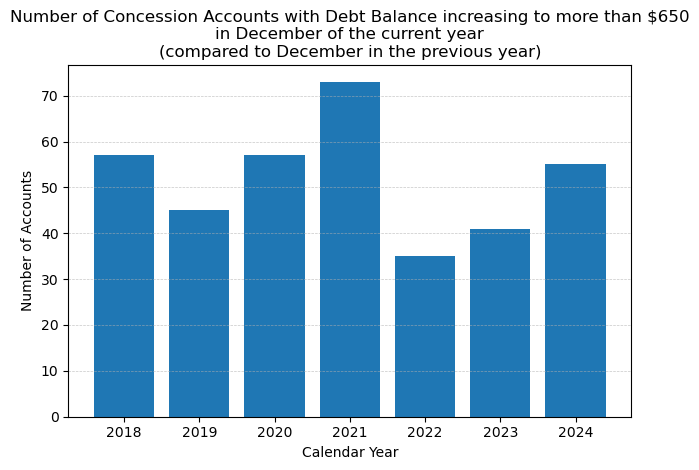

In [37]:
import matplotlib.pyplot as plt

# Count the number of rows per calendar year in summary_df
year_counts = summary_df['calendar_year'].value_counts().sort_index()

# Plot
plt.figure()
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel('Calendar Year')
plt.ylabel('Number of Accounts')
plt.title(
    'Number of Concession Accounts with Debt Balance increasing to more than $650\n'
    'in December of the current year\n'
    '(compared to December in the previous year)'
)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [40]:


file_path = r'C:\Users\andrew.dilley\development\URGS\URGS_account.csv'

# Load the CSV data into a DataFrame
URGS_df = pd.read_csv(file_path)



# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(URGS_df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
URGS_df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(URGS_df.describe())
URGS_df.columns      # list of all column names


First 5 rows of the dataset:
   pk_account  amount                                   description  \
0    30038843   500.0  URGs Application - Successful - FC2017/07269   
1    30037503     NaN  URGs Application - Successful - FC2017/07959   
2    30018280     NaN  URGs Application - Successful - FC2017/07960   
3    30082945   500.0  URGs Application - Successful - FC2017/07961   
4    30035451   500.0  URGs Application - Successful - FC2017/08215   

  evt_datetime  
0   27/07/2017  
1   16/08/2017  
2   16/08/2017  
3   16/08/2017  
4   23/08/2017  

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pk_account    1451 non-null   int64  
 1   amount        1174 non-null   float64
 2   description   1450 non-null   object 
 3   evt_datetime  1451 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 

Index(['pk_account', 'amount', 'description', 'evt_datetime'], dtype='object')

In [45]:
import pandas as pd

# Convert evt_datetime column to pandas datetime64[ns] type (date-only)
URGS_df['evt_datetime'] = pd.to_datetime(URGS_df['evt_datetime']).dt.normalize()


In [46]:

# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(URGS_df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
URGS_df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(URGS_df.describe())
URGS_df.columns      # list of all column names


First 5 rows of the dataset:
   pk_account  amount                                   description  \
0    30038843   500.0  URGs Application - Successful - FC2017/07269   
1    30037503     NaN  URGs Application - Successful - FC2017/07959   
2    30018280     NaN  URGs Application - Successful - FC2017/07960   
3    30082945   500.0  URGs Application - Successful - FC2017/07961   
4    30035451   500.0  URGs Application - Successful - FC2017/08215   

  evt_datetime  
0   2017-07-27  
1   2017-08-16  
2   2017-08-16  
3   2017-08-16  
4   2017-08-23  

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pk_account    1451 non-null   int64         
 1   amount        1174 non-null   float64       
 2   description   1450 non-null   object        
 3   evt_datetime  1451 non-null   datetime64[ns]
dtypes: date

Index(['pk_account', 'amount', 'description', 'evt_datetime'], dtype='object')

In [47]:
summary_df.columns

Index(['pk_account', 'calendar_year', 'amt_debit_prev_year',
       'amt_debit_current_year'],
      dtype='object')

In [48]:
# Find the set of pk_accounts that appear in both DataFrames
common_accounts = set(summary_df['pk_account']).intersection(URGS_df['pk_account'])

# Create reduced_df with only those common accounts
reduced_df = summary_df[summary_df['pk_account'].isin(common_accounts)].copy()

# Drop them from the original summary_df
summary_df = summary_df[~summary_df['pk_account'].isin(common_accounts)].copy()

# Quick checks
print(f"reduced_df rows: {len(reduced_df)}")
print(f"remaining summary_df rows: {len(summary_df)}")


reduced_df rows: 270
remaining summary_df rows: 93


In [51]:
# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(summary_df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
summary_df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(summary_df.describe())


First 5 rows of the dataset:
    pk_account  calendar_year  amt_debit_prev_year  amt_debit_current_year
0     10000869           2018              1216.49                 1311.63
3     10001546           2024               193.69                  801.65
13    10004924           2024               310.76                  921.15
15    10005990           2021                 0.00                 1624.97
16    10006371           2021               363.59                 1411.59

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0 to 358
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pk_account              93 non-null     int64  
 1   calendar_year           93 non-null     int32  
 2   amt_debit_prev_year     93 non-null     float64
 3   amt_debit_current_year  93 non-null     float64
dtypes: float64(2), int32(1), int64(1)
memory usage: 3.3 KB

Summary statistics f

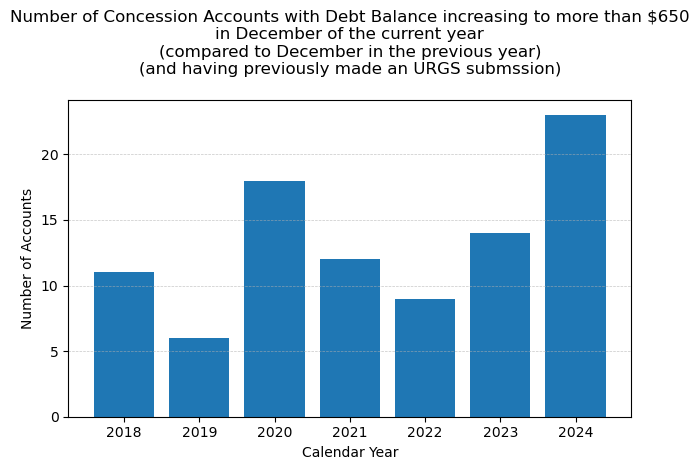

In [53]:
import matplotlib.pyplot as plt

# Count the number of rows per calendar year in summary_df
year_counts = summary_df['calendar_year'].value_counts().sort_index()

# Plot
plt.figure()
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel('Calendar Year')
plt.ylabel('Number of Accounts')
plt.title(
    'Number of Concession Accounts with Debt Balance increasing to more than $650\n'
    'in December of the current year\n'
    '(compared to December in the previous year)\n'
    '(and having previously made an URGS submssion)\n'
    
)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


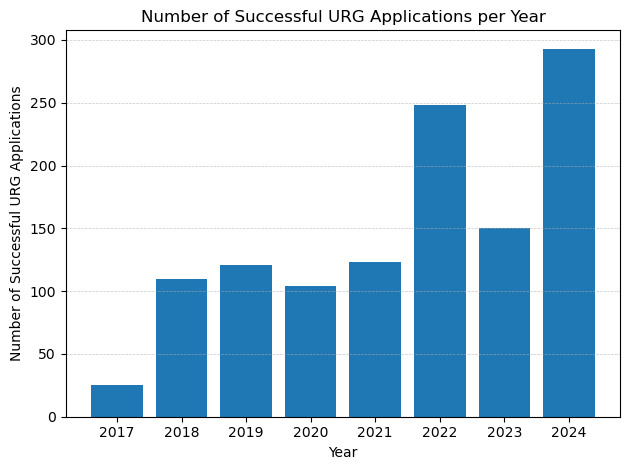

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Make sure evt_datetime is a true datetime
URGS_df['evt_datetime'] = pd.to_datetime(URGS_df['evt_datetime'])

# 2. Define “successful” as amount > 0
successful = URGS_df[URGS_df['amount'] > 0].copy()

# 3. Extract year
successful['year'] = successful['evt_datetime'].dt.year

# 4. Count applications per year
year_counts = successful['year'].value_counts().sort_index()

# 5. Plot
plt.figure()
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Successful URG Applications')
plt.title('Number of Successful URG Applications per Year')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [69]:
import pandas as pd

file_path = r'C:\Users\andrew.dilley\development\URGS\HistoricDebtProfile.csv'

# Load the CSV data into a DataFrame
df = pd.read_csv(file_path)



# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(df.describe())
df.columns      # list of all column names


First 5 rows of the dataset:
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit
0             201718     12   121488    30084795   Social Security       0.95
1             201920     12    55628    30059774   Social Security       0.00
2             202122     12   124737    30099129   Social Security      74.90
3             201920     12    73972    30088800   Social Security     178.91
4             201718     12     2704    10003327   Social Security     171.72

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41067 non-null  int64  
 1   month              41067 non-null  int64  
 2   pk_porg            41067 non-null  int64  
 3   pk_account         41067 non-null  int64  
 4   pension_type_desc  39445 non-null  object 
 5   amt_debit          41067 non-n

Index(['fk_financial_year', 'month', 'pk_porg', 'pk_account',
       'pension_type_desc', 'amt_debit'],
      dtype='object')

In [70]:
# ensure fk_financial_year is stringy, then slice and convert to int
df['calendar_year'] = (
    df['fk_financial_year']
    .astype(str)    # in case it’s numeric
    .str[:4]        # grab the first four characters
    .astype(int)    # convert back to integer
)


In [71]:

# Inspect the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame, including the data types of each column
print("\nDataFrame information:")
df.info()

# Get summary statistics for numerical columns (if applicable)
print("\nSummary statistics for numerical columns:")
print(df.describe())
df.columns      # list of all column names


First 5 rows of the dataset:
   fk_financial_year  month  pk_porg  pk_account pension_type_desc  amt_debit  \
0             201718     12   121488    30084795   Social Security       0.95   
1             201920     12    55628    30059774   Social Security       0.00   
2             202122     12   124737    30099129   Social Security      74.90   
3             201920     12    73972    30088800   Social Security     178.91   
4             201718     12     2704    10003327   Social Security     171.72   

   calendar_year  
0           2017  
1           2019  
2           2021  
3           2019  
4           2017  

DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41067 entries, 0 to 41066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fk_financial_year  41067 non-null  int64  
 1   month              41067 non-null  int64  
 2   pk_porg            41067 non-null  int64 

Index(['fk_financial_year', 'month', 'pk_porg', 'pk_account',
       'pension_type_desc', 'amt_debit', 'calendar_year'],
      dtype='object')

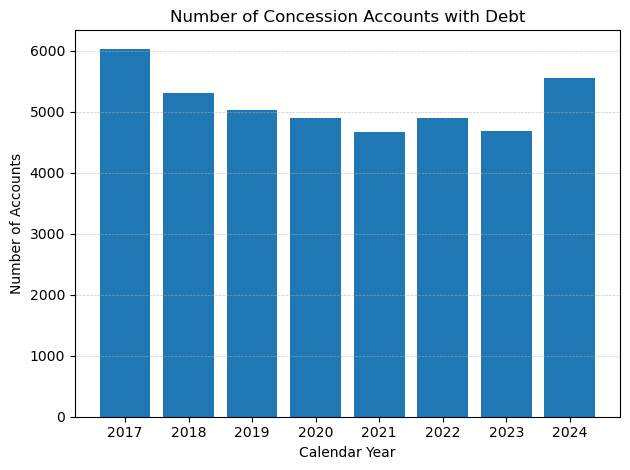

In [72]:
# Count the number of rows per calendar year in summary_df
year_counts = df['calendar_year'].value_counts().sort_index()

# Plot
plt.figure()
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel('Calendar Year')
plt.ylabel('Number of Accounts')
plt.title(
    'Number of Concession Accounts with Debt'
)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


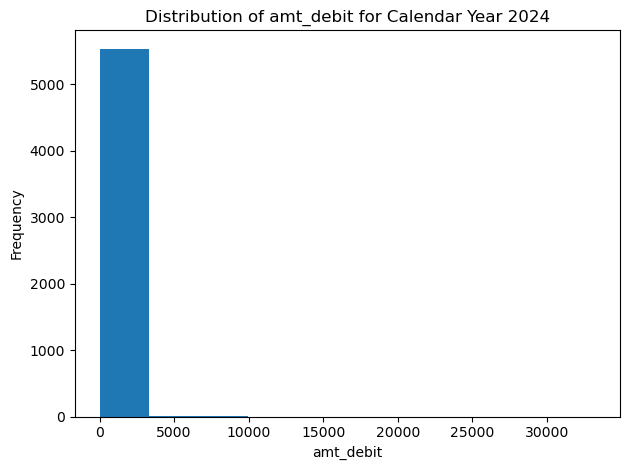

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (adjust filename/format as needed)
df = pd.read_csv('HistoricDebtProfile.csv')  # or pd.read_excel(...)

# Extract calendar_year and amt_debit if not already present
df['calendar_year'] = df['fk_financial_year'].astype(str).str[:4].astype(int)

# Filter for 2024
df_2024 = df[df['calendar_year'] == 2024]

# Plot histogram
plt.figure()
plt.hist(df_2024['amt_debit'], bins=10)
plt.xlabel('amt_debit')
plt.ylabel('Frequency')
plt.title('Distribution of amt_debit for Calendar Year 2024')
plt.tight_layout()
plt.show()


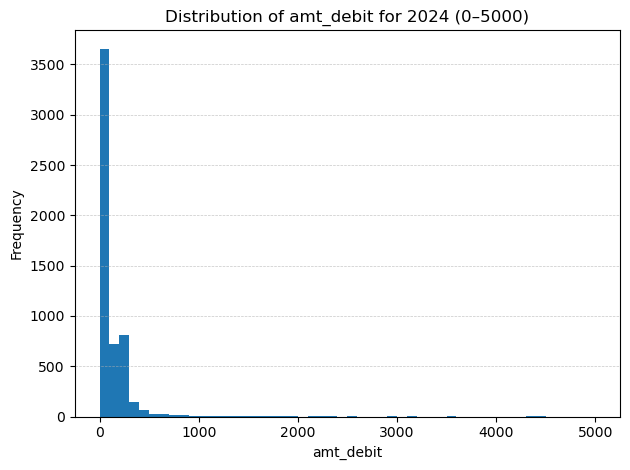

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for 2024 and amt_debit between 0 and 5000
df_2024 = df[
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 0) &
    (df['amt_debit'] <= 5000)
]

# Define 100‑unit bins from 0 up to 5000
bins = np.arange(0, 5001, 100)

plt.figure()
plt.hist(df_2024['amt_debit'], bins=bins)
plt.xlabel('amt_debit')
plt.ylabel('Frequency')
plt.title('Distribution of amt_debit for 2024 (0–5000)')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


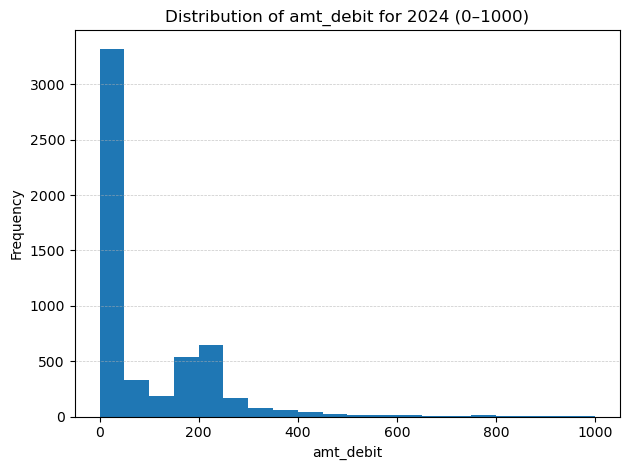

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Filter for 2024 and amt_debit between 0 and 1000
df_2024_small = df[
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 0) &
    (df['amt_debit'] <= 1000)
]

# Define 50‑unit bins from 0 up to 1000
bins = np.arange(0, 1001, 50)

plt.figure()
plt.hist(df_2024_small['amt_debit'], bins=bins)
plt.xlabel('amt_debit')
plt.ylabel('Frequency')
plt.title('Distribution of amt_debit for 2024 (0–1000)')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


In [76]:
# If you want it across all years:
count_all = df[df['amt_debit'] > 650].shape[0]
print(f"Total records with amt_debit > 650: {count_all}")

# If you want it just for 2024:
count_2024 = df[
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] > 650)
].shape[0]
print(f"Records in 2024 with amt_debit > 650: {count_2024}")


Total records with amt_debit > 650: 842
Records in 2024 with amt_debit > 650: 105


In [77]:
# Across all years
count_all_100_400 = df[
    (df['amt_debit'] >= 100) &
    (df['amt_debit'] <= 400)
].shape[0]
print(f"Total records with amt_debit between 100 and 400: {count_all_100_400}")

# Just for 2024
count_2024_100_400 = df[
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 100) &
    (df['amt_debit'] <= 400)
].shape[0]
print(f"Records in 2024 with amt_debit between 100 and 400: {count_2024_100_400}")


Total records with amt_debit between 100 and 400: 8958
Records in 2024 with amt_debit between 100 and 400: 1678


In [78]:
# Define a base filter for rows with a pension_type_desc
has_pension = df['pension_type_desc'].notna()

# Count all years with amt_debit between 100 and 400 and a valid pension_type_desc
count_all_100_400 = df[
    has_pension &
    (df['amt_debit'] >= 100) &
    (df['amt_debit'] <= 400)
].shape[0]
print(f"Total records (all years) with amt_debit between 100 and 400 and pension_type_desc: {count_all_100_400}")

# Count just for 2024
count_2024_100_400 = df[
    has_pension &
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 100) &
    (df['amt_debit'] <= 400)
].shape[0]
print(f"Records in 2024 with amt_debit between 100 and 400 and pension_type_desc: {count_2024_100_400}")


Total records (all years) with amt_debit between 100 and 400 and pension_type_desc: 8450
Records in 2024 with amt_debit between 100 and 400 and pension_type_desc: 1571


In [79]:
# Base filter: only rows with a pension_type_desc
has_pension = df['pension_type_desc'].notna()

# Total, all years
count_all_gt650 = df[
    has_pension &
    (df['amt_debit'] > 650)
].shape[0]
print(f"Total records (all years) with amt_debit > 650 and pension_type_desc: {count_all_gt650}")

# Just for 2024
count_2024_gt650 = df[
    has_pension &
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] > 650)
].shape[0]
print(f"Records in 2024 with amt_debit > 650 and pension_type_desc: {count_2024_gt650}")


Total records (all years) with amt_debit > 650 and pension_type_desc: 695
Records in 2024 with amt_debit > 650 and pension_type_desc: 79


In [80]:
# Base filter for rows with a pension_type_desc
has_pension = df['pension_type_desc'].notna()

# Count for 2024, amt_debit between 300 and 400
count_2024_300_400 = df[
    has_pension &
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 300) &
    (df['amt_debit'] <= 400)
].shape[0]

print(f"Records in 2024 with amt_debit between 300 and 400 and pension_type_desc: {count_2024_300_400}")


Records in 2024 with amt_debit between 300 and 400 and pension_type_desc: 130


In [82]:
# Base filter for rows with a pension_type_desc
has_pension = df['pension_type_desc'].notna()

# Count for 2024, amt_debit between 250 and 400
count_2024_250_400 = df[
    has_pension &
    (df['calendar_year'] == 2024) &
    (df['amt_debit'] >= 250) &
    (df['amt_debit'] <= 400)
].shape[0]

print(f"Records in 2024 with amt_debit between 200 and 400 and pension_type_desc: {count_2024_250_400}")


Records in 2024 with amt_debit between 200 and 400 and pension_type_desc: 285


In [83]:
import pandas as pd

# Ensure evt_datetime is datetime
URGS_df['evt_datetime'] = pd.to_datetime(URGS_df['evt_datetime'])

# Count records in 2024
count_2024 = URGS_df[URGS_df['evt_datetime'].dt.year == 2024].shape[0]
print(f"Number of URGS_df records in 2024: {count_2024}")


Number of URGS_df records in 2024: 327
